# Imports

In [2]:
# Third Party
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from sqlalchemy import create_engine
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary

# Native
import os

# Load Data

In [3]:
# PostgreSQL credentials and database details
load_dotenv() # take environment variables from .env.
db_user = os.getenv("POSTGRESQL_USERNAME")
db_password = os.getenv("POSTGRESQL_PWD")
db_host = 'localhost' # Or your PostgreSQL server IP/hostname
db_port = '5432'      # Default PostgreSQL port
db_name = 'tile_db'

In [4]:
cluster_label = 'cluster_label' # norm_cluster_label , cluster_label
table_name = 'miles_walked_by_cluster' if cluster_label == 'cluster_label' else 'miles_walked_by_norm_cluster'
tagquery = f"""
SELECT 
	t.{cluster_label},
	t.tag,
	mn.miles_walked_in_cluster

FROM tags as t
INNER JOIN {table_name} as mn
ON t.{cluster_label} = mn.{cluster_label}
;
"""
weatherquery = f"""
WITH weather_data as (SELECT 
	tdj.{cluster_label},
	AVG(w.temperature_2m) as temperature_C,
	AVG(w.relative_humidity_2m) as rel_humidity,
	AVG(w.cloud_cover) AS cloud_cover,
	AVG(w.is_day) AS is_day,
	AVG(w.precipitation) AS precipitation,
    AVG(w.elevation_meters_asl) AS elevation
FROM weather as w
INNER JOIN tile_data_john as tdj
ON w.index = tdj.index
GROUP BY tdj.{cluster_label})

SELECT
	m.miles_walked_in_cluster,
	w.*
FROM {table_name} as m
INNER JOIN weather_data as w
ON m.{cluster_label} = w.{cluster_label}
;
"""
engine = create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')
tagdf = pd.read_sql(tagquery, con = engine)
weatherdf = pd.read_sql(weatherquery, con = engine)

df = pd.merge(weatherdf, tagdf[[cluster_label,'tag']], how='left', on=cluster_label)
df

,miles_walked_in_cluster,cluster_label,temperature_c,rel_humidity,cloud_cover,is_day,precipitation,elevation,tag
0,233.318354,-1,17.879863,76.068490,62.162948,0.492202,0.165359,387.606589,outlier
1,167.208036,2095,20.696667,58.144560,24.750000,0.833333,0.000000,852.833333,street_address
2,167.208036,2095,20.696667,58.144560,24.750000,0.833333,0.000000,852.833333,subpremise
3,167.208036,2095,20.696667,58.144560,24.750000,0.833333,0.000000,852.833333,establishment
4,167.208036,2095,20.696667,58.144560,24.750000,0.833333,0.000000,852.833333,point_of_interest
...,...,...,...,...,...,...,...,...,...
6293,0.000671,2992,26.932500,91.984435,99.583333,0.166667,0.008333,20.000000,store
6294,0.000671,2992,26.932500,91.984435,99.583333,0.166667,0.008333,20.000000,veterinary_care
6295,0.000671,2992,26.932500,91.984435,99.583333,0.166667,0.008333,20.000000,street_address
6296,0.000671,2992,26.932500,91.984435,99.583333,0.166667,0.008333,20.000000,plus_code


# Weather Data Exploration

In [4]:
lowq = df['miles_walked_in_cluster'].quantile(.25)
highq = df['miles_walked_in_cluster'].quantile(.9)
print(f"Including data between {lowq:.2f} and {highq:.2f} miles walked")
cdf = df[(df[cluster_label]>=0) & (df['miles_walked_in_cluster'].between(lowq,highq))].copy()
X = cdf[['temperature_c','rel_humidity','cloud_cover','is_day','precipitation']]
y = cdf['miles_walked_in_cluster']
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X))
X.corrwith(y)

Including data between 0.06 and 1.11 miles walked


0    0.028882
1   -0.023932
2    0.089733
3    0.120987
4    0.015642
dtype: float64

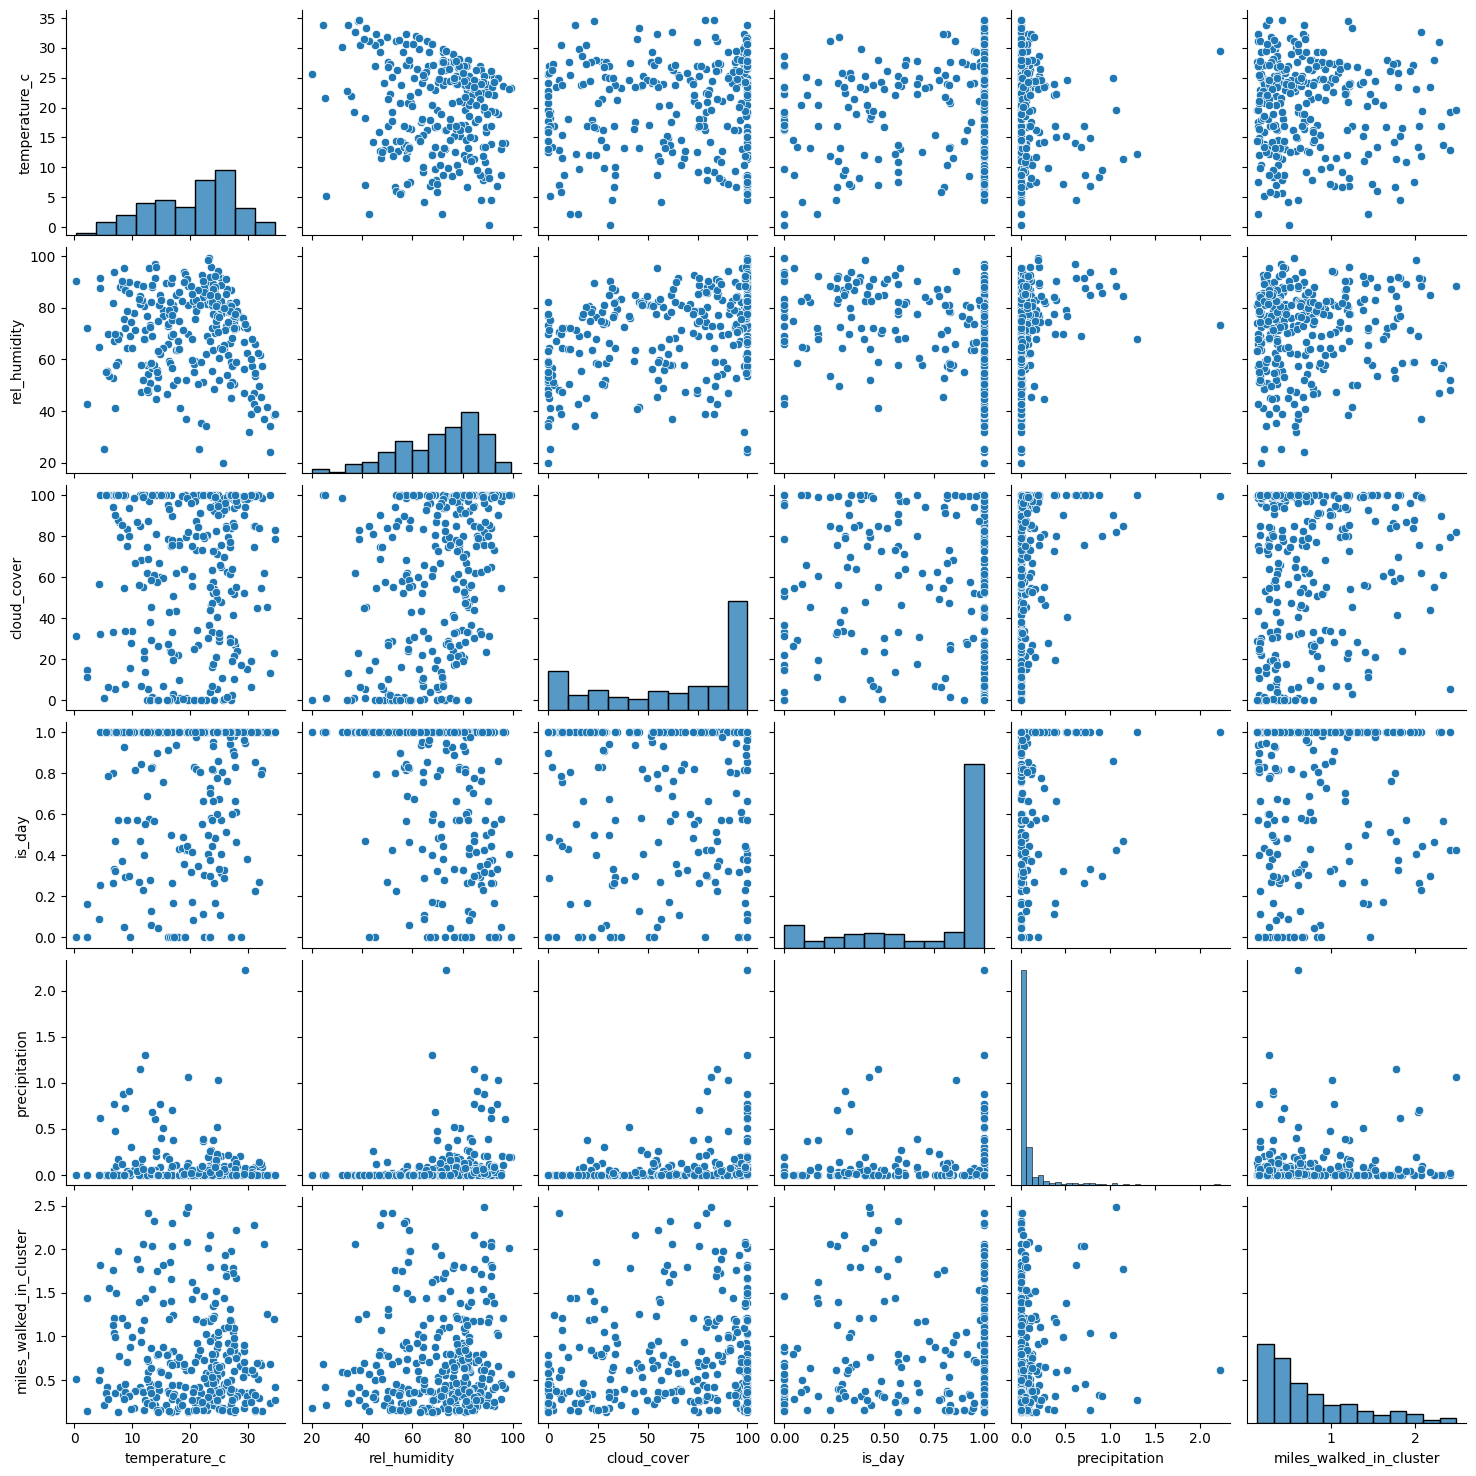

In [206]:
sns.pairplot(cdf[['temperature_c','rel_humidity','cloud_cover','is_day','precipitation','miles_walked_in_cluster']])

In [16]:
df.head()

,miles_walked_in_cluster,cluster_label,temperature_c,rel_humidity,cloud_cover,is_day,precipitation,elevation,tag
0,233.318354,-1,18.504318,76.747098,63.000893,0.509878,0.194324,197.482699,outlier
1,167.208036,2095,7.330000,56.494829,69.900000,0.080000,0.000000,43.000000,establishment
2,167.208036,2095,7.330000,56.494829,69.900000,0.080000,0.000000,43.000000,museum
3,167.208036,2095,7.330000,56.494829,69.900000,0.080000,0.000000,43.000000,point_of_interest
4,167.208036,2095,7.330000,56.494829,69.900000,0.080000,0.000000,43.000000,street_address


In [9]:
allweather_query = """
SELECT * FROM weather
"""
wdf = pd.read_sql(allweather_query, con=engine)
wdf

,index,date,time,weather_hour,latitude,longitude,elevation_meters_asl,temperature_2m,relative_humidity_2m,rain,weather_code,wind_speed_10m,cloud_cover,cloud_cover_low,cloud_cover_high,cloud_cover_mid,is_day,sunshine_duration,precipitation,snowfall,apparent_temperature,pressure_msl,surface_pressure,wind_direction_10m,wind_gusts_10m,tile_name
0,0,2024-10-28,06:54:25,2024-10-28 06:00:00,42.096405,-86.488891,205.0,6.9655,64.44732,0.0,1.0,14.348156,28.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,2.861774,1023.7,998.48230,160.20103,23.400000,John
1,1,2024-10-28,07:02:04,2024-10-28 07:00:00,42.096386,-86.488880,205.0,6.7155,64.62286,0.0,3.0,15.244842,98.0,0.0,98.0,0.0,0.0,0.0,0.0,0.0,2.448909,1023.5,998.26526,157.06787,25.199999,John
2,2,2024-10-28,07:02:16,2024-10-28 07:00:00,42.096405,-86.488891,205.0,6.7155,64.62286,0.0,3.0,15.244842,98.0,0.0,98.0,0.0,0.0,0.0,0.0,0.0,2.448909,1023.5,998.26526,157.06787,25.199999,John
3,3,2024-10-28,07:09:38,2024-10-28 07:00:00,42.096461,-86.488998,205.0,6.7155,64.62286,0.0,3.0,15.244842,98.0,0.0,98.0,0.0,0.0,0.0,0.0,0.0,2.448909,1023.5,998.26526,157.06787,25.199999,John
4,4,2024-10-28,07:24:41,2024-10-28 07:00:00,42.096375,-86.488851,205.0,6.7155,64.62286,0.0,3.0,15.244842,98.0,0.0,98.0,0.0,0.0,0.0,0.0,0.0,2.448909,1023.5,998.26526,157.06787,25.199999,John
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65593,65593,2025-06-04,13:59:37,2025-06-04 13:00:00,-34.577209,-58.439284,21.0,12.2480,93.61442,0.0,3.0,6.489992,100.0,1.0,100.0,1.0,1.0,3600.0,0.0,0.0,11.687475,1013.3,1010.75680,326.30990,17.280000,John
65594,65594,2025-06-04,14:13:30,2025-06-04 14:00:00,-34.577209,-58.439284,21.0,13.5980,89.76218,0.0,3.0,6.842368,95.0,3.0,95.0,0.0,1.0,3600.0,0.0,0.0,13.205338,1013.7,1011.16750,324.63745,19.440000,John
65595,65595,2025-06-04,14:16:09,2025-06-04 14:00:00,-34.577223,-58.439284,21.0,13.5980,89.76218,0.0,3.0,6.842368,95.0,3.0,95.0,0.0,1.0,3600.0,0.0,0.0,13.205338,1013.7,1011.16750,324.63745,19.440000,John
65596,65596,2025-06-04,14:20:40,2025-06-04 14:00:00,-34.577223,-58.439284,21.0,13.5980,89.76218,0.0,3.0,6.842368,95.0,3.0,95.0,0.0,1.0,3600.0,0.0,0.0,13.205338,1013.7,1011.16750,324.63745,19.440000,John


In [15]:
chart = alt.Chart(wdf[::100]).mark_circle().encode(
    x = 'date:O',
    y = 'elevation_meters_asl:N'
)
chart

alt.Chart(...)

# Tags Data Exploration

<BarContainer object of 25 artists>

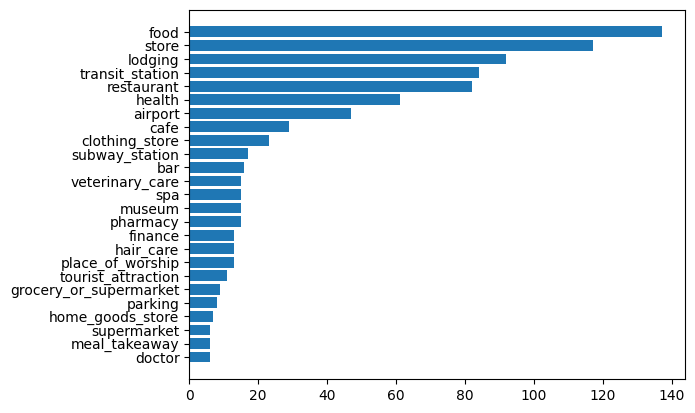

In [32]:
tag_counts = tagdf['tag'].value_counts().sort_values(ascending=True).reset_index()
not_interesting_tags = list(tag_counts['tag'].tail(7).values) + ['political'] + [tag for tag in tag_counts['tag'].unique() if 'locality' in tag]
tag_counts = tag_counts[(tag_counts['count'] > 5) & (~tag_counts['tag'].isin(not_interesting_tags))]
fig, ax = plt.subplots()
ax.barh(y=tag_counts['tag'], width=tag_counts['count'].values)

# Data Prep

In [33]:
# remove boring tags and any that show up less than 5 times from above
mldf = df[tagdf['tag'].isin(tag_counts['tag'])]
# from initial exploration, models perform awful on clusters with miles walked > 10 -- must be something weird happening
# realistically we only had ~3-4 days when we walked more than 10 miles
lowq = df['miles_walked_in_cluster'].quantile(.1)
highq = df['miles_walked_in_cluster'].quantile(.9)
print(f"Including data between {lowq:.2f} and {highq:.2f} miles walked")
mldf = mldf[df['miles_walked_in_cluster'].between(lowq,highq)].copy()
tags = list(tag_counts['tag'].values)
mldf.loc[:, tags] = pd.get_dummies(mldf['tag'], dtype=float)
mldf = mldf[[cluster_label, 'miles_walked_in_cluster','temperature_c','rel_humidity','cloud_cover','is_day','precipitation'] + tags]
mldf = mldf.groupby(cluster_label).max().reset_index().dropna(axis=1, how='all')
mldf

Including data between 0.01 and 1.10 miles walked


C:\Users\joyam\AppData\Local\Temp\ipykernel_6580\1167977408.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mldf = mldf[df['miles_walked_in_cluster'].between(lowq,highq)].copy()


,cluster_label,miles_walked_in_cluster,temperature_c,rel_humidity,cloud_cover,is_day,precipitation,doctor,home_goods_store,parking,grocery_or_supermarket,tourist_attraction,place_of_worship,hair_care,finance,pharmacy,museum,spa,veterinary_care,subway_station,clothing_store,cafe,airport,health,restaurant,transit_station,lodging,store,food
0,2,0.176681,30.105334,31.823491,98.428571,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10,0.263219,21.677586,82.856019,100.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13,1.027868,12.009500,54.601165,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,25,0.084581,16.066854,64.661242,98.958333,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,81,0.114960,11.004100,72.640873,20.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,3009,0.139262,10.902542,78.188442,39.255556,0.605556,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
402,3016,0.163470,22.203166,93.602125,83.833333,0.166667,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
403,3017,0.141374,26.179371,68.712436,80.782609,0.565217,0.004348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404,3019,0.119875,25.038000,67.753641,99.466667,1.000000,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
X = mldf.drop(columns=[cluster_label,'miles_walked_in_cluster'])
y = mldf['miles_walked_in_cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 69)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(f"training: {X_train.shape[0]}\ntesting: {X_test.shape[0]}")

training: 324
testing: 82


In [35]:
X.corrwith(y).sort_values(ascending=False)

lodging                   0.155940
home_goods_store          0.134179
spa                       0.106862
temperature_c             0.075153
tourist_attraction        0.066539
cafe                      0.047379
pharmacy                  0.032588
hair_care                 0.030583
grocery_or_supermarket    0.027753
transit_station           0.027389
is_day                    0.026525
finance                   0.019137
food                      0.001980
rel_humidity             -0.005922
health                   -0.008456
precipitation            -0.010808
restaurant               -0.012490
parking                  -0.016629
subway_station           -0.021199
store                    -0.026985
veterinary_care          -0.027314
doctor                   -0.029324
clothing_store           -0.033264
cloud_cover              -0.040647
airport                  -0.046139
place_of_worship         -0.049149
museum                   -0.051297
dtype: float64

# Modelling

## Simple

In [36]:
def plot_results(y_pred, y_test, ax1, ax2, title):
    z = np.polyfit(y_pred, y_test, 1)
    p = np.poly1d(z)
    ax1.scatter(y_pred,y_test);
    ax1.plot(y_pred, p(y_pred), "r-", linewidth=.5)
    ax1.set_xlabel('Predicted');
    ax1.set_ylabel('True');
    ax1.set_title(title)
    ax2.hist(y_pred-y_test, bins=20);
    ax2.set_xlabel('Residual');
    ax2.set_ylabel('Count');

In [37]:
lr = LinearRegression()
scores = cross_validate(lr,X,y,cv=10)
print(np.mean(scores['test_score']))

lr = Lasso()
scores = cross_validate(lr,X,y,cv=10)
print(np.mean(scores['test_score']))

lr = Ridge()
scores = cross_validate(lr,X,y,cv=10)
print(np.mean(scores['test_score']))

-0.18224855450926167
-0.05001081401113814
-0.12249693473214422


-0.12502387719443808
-0.00014970240577372174
-0.12438625658385583
-0.23899453279257488


C:\Users\joyam\AppData\Local\Temp\ipykernel_6580\464861256.py:2: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(y_pred, y_test, 1)


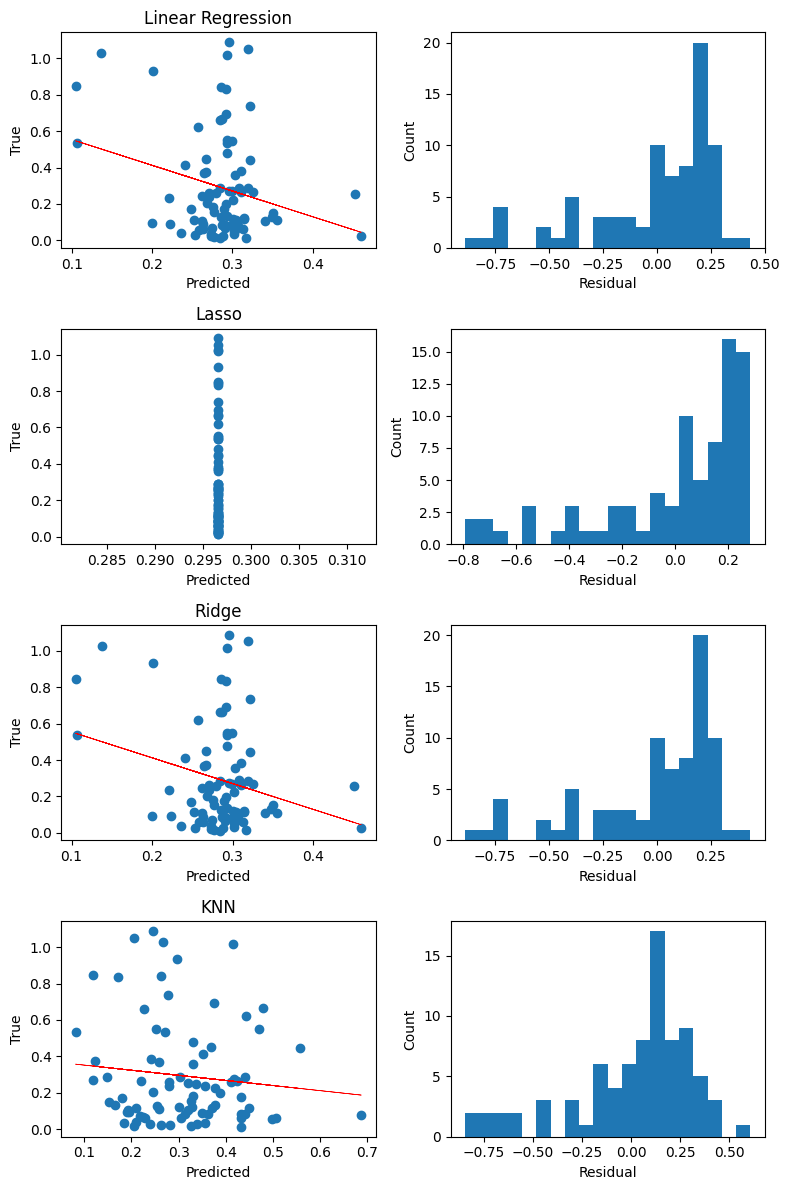

In [38]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
print(lr.score(X_test, y_test))

la = Lasso()
la.fit(X_train, y_train)
la_pred = la.predict(X_test)
print(la.score(X_test, y_test))

ri = Ridge()
ri.fit(X_train, y_train)
ri_pred = ri.predict(X_test)
print(ri.score(X_test, y_test))

knn = KNeighborsRegressor(n_neighbors = 5, n_jobs=-1)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print(knn.score(X_test, y_test))

fig, ax = plt.subplots(4,2, figsize=(8,12), layout='tight')
plot_results(lr_pred, y_test, ax[0,0], ax[0,1], 'Linear Regression')
plot_results(la_pred, y_test, ax[1,0], ax[1,1], 'Lasso')
plot_results(ri_pred, y_test, ax[2,0], ax[2,1], 'Ridge')
plot_results(knn_pred, y_test, ax[3,0], ax[3,1], 'KNN')

## Simple +

In [39]:
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X)
lr = LinearRegression()
lr_scores = cross_validate(lr,X_poly,y,cv=10, return_estimator=True)
print(np.mean(scores['test_score']))

lr = Lasso()
scores = cross_validate(lr,X_poly,y,cv=10)
print(np.mean(scores['test_score']))

lr = Ridge()
scores = cross_validate(lr,X_poly,y,cv=10)
print(np.mean(scores['test_score']))

-0.12249693473214422
-0.054421744973596475
-2.7238420640461825


In [40]:
lr_best = lr_scores['estimator'][np.argmax(lr_scores['test_score'])]
f"{poly.get_feature_names_out()[np.argmax(lr_best.coef_)]} : {np.max(lr_best.coef_)}"
feature_names = poly.get_feature_names_out()
feature_values = lr_best.coef_
feats = {name:value for name, value in zip(feature_names, feature_values)}
feats = {k:v for k,v in sorted(feats.items(), key=lambda item: -item[1])}
feats

{'precipitation store': np.float64(1.7638956082107586),
 'precipitation': np.float64(0.9704845929897274),
 'store food': np.float64(0.7467184191885071),
 'health': np.float64(0.6961936479172017),
 'health^2': np.float64(0.6961936478987286),
 'cafe store': np.float64(0.5883684967568542),
 'pharmacy store': np.float64(0.5514399493601155),
 'is_day health': np.float64(0.5363921180314734),
 'is_day cafe': np.float64(0.5044517437066472),
 'is_day doctor': np.float64(0.29896211649511434),
 'precipitation health': np.float64(0.29533453609430643),
 'precipitation lodging': np.float64(0.29489633497050866),
 'precipitation cafe': np.float64(0.24366158569830698),
 'cafe food': np.float64(0.2181988669523303),
 'is_day': np.float64(0.17747987616303612),
 'store': np.float64(0.16888950432227146),
 'store^2': np.float64(0.16888950431968341),
 'rel_humidity transit_station': np.float64(0.10291951968486186),
 'is_day precipitation': np.float64(0.10008451188714446),
 'is_day^2': np.float64(0.09816142863

## Pytorch

In [13]:
df.head(3)

,miles_walked_in_cluster,cluster_label,temperature_c,rel_humidity,cloud_cover,is_day,precipitation,elevation,tag
0,233.318354,-1,17.879863,76.06849,62.162948,0.492202,0.165359,387.606589,outlier
1,167.208036,2095,20.696667,58.14456,24.750000,0.833333,0.000000,852.833333,street_address
2,167.208036,2095,20.696667,58.14456,24.750000,0.833333,0.000000,852.833333,subpremise


In [12]:
df.shape

(6298, 9)

In [18]:
# Process Data
cdf = df[(df['cluster_label'] > 0) & (df['miles_walked_in_cluster'] < 10)].copy()
tags = list(cdf['tag'].unique())
cdf.loc[:, tags] = pd.get_dummies(cdf['tag'], dtype=float)
cdf = cdf.groupby(['cluster_label']).first().reset_index()

In [19]:


svd = TruncatedSVD(n_components=4)
scaler = StandardScaler()
X = cdf.drop(columns=['miles_walked_in_cluster','tag','cluster_label'])
y = cdf['miles_walked_in_cluster'].astype(float)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3, random_state=66)
# X_train = svd.fit_transform(X_train)
X_train = scaler.fit_transform(X_train)
sample_weights_train = np.ones((X_train.shape[0],1))
# X_val = svd.transform(X_val)
X_val = scaler.transform(X_val)
sample_weights_val = np.ones((X_val.shape[0],1))
# Convert NumPy arrays to PyTorch tensors
X_train = torch.from_numpy(X_train).to(torch.float32)
y_train = torch.from_numpy(np.array(y_train).reshape(-1,1)).to(torch.float32)
sample_weights_train = torch.from_numpy(sample_weights_train).to(torch.float32)
X_val = torch.from_numpy(X_val).to(torch.float32)
y_val = torch.from_numpy(np.array(y_val).reshape(-1,1)).to(torch.float32)
sample_weights_val = torch.from_numpy(sample_weights_val).to(torch.float32)

# Create Datasets
train_dataset = TensorDataset(X_train, y_train, sample_weights_train)
val_dataset = TensorDataset(X_val, y_val, sample_weights_val)

# Create DataLoaders
BATCH_SIZE = 64 # X_train.shape[0]
NUM_WORKERS = os.cpu_count() - 1
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS) # No need to shuffle validation data

print(f"Batch size: {BATCH_SIZE}")
print(f"Number of training batches per epoch: {len(train_loader)}")
print(f"Number of validation batches per epoch: {len(val_loader)}")

Batch size: 64
Number of training batches per epoch: 9
Number of validation batches per epoch: 4


In [26]:
class DeeperNN(nn.Module):
    def __init__(self, input_features, hidden_features, output_features):
        super(DeeperNN, self).__init__()
        self.input = nn.Linear(input_features, hidden_features)
        self.bn = nn.BatchNorm1d(hidden_features) # Normalizes across the feature dimension (hidden_features)
        self.dropout = nn.Dropout(p=.5) # Dropout after activation
        self.hidden_layer = nn.Linear(hidden_features,hidden_features)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(hidden_features, output_features)

    def forward(self, x):
        x = self.input(x)
        # x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)

        # x = self.hidden_layer(x)
        # x = self.bn(x)
        # x = self.relu(x)
        # x = self.dropout(x)

        # x = self.hidden_layer(x)
        # x = self.bn(x)
        # x = self.relu(x)
        # x = self.dropout(x)

        x = self.output_layer(x)
        return x
    
model = DeeperNN(input_features=X_train.shape[1], hidden_features=16, output_features=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Early Stopping Parameters
patience = 50 # How many epochs to wait for improvement before stopping
min_delta = 0.0001

best_val_loss = float('inf') # Initialize with a very large number
epochs_no_improve = 0
early_stop = False
summary(model, input_size= (X_train.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]           1,152
              ReLU-2                   [-1, 16]               0
           Dropout-3                   [-1, 16]               0
            Linear-4                    [-1, 1]              17
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [30]:
# Training Loop
num_epochs = 100

print("\nStarting training...")
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    total_train_loss = 0 # To accumulate loss over all batches
    for batch_X, batch_y, batch_weights in train_loader: # Iterate over batches
        optimizer.zero_grad()
        y_predicted_train = model(batch_X)

        loss_individual_train = criterion(y_predicted_train, batch_y)
        weighted_loss_train = loss_individual_train * batch_weights
        loss_train = weighted_loss_train.mean() # Average weighted loss for the batch

        loss_train.backward()
        optimizer.step()
        total_train_loss += loss_train.item() * batch_X.size(0) # Accumulate weighted loss, scaled by batch size

    avg_train_loss = total_train_loss / X_train.size(0) # Average loss over all training samples

    # --- Validation Phase ---
    model.eval()
    total_val_loss = 0 # To accumulate loss over all batches
    with torch.no_grad():
        for batch_X_val, batch_y_val, batch_weights_val in val_loader: # Iterate over validation batches
            y_predicted_val = model(batch_X_val)
            loss_individual_val = criterion(y_predicted_val, batch_y_val)
            # weighted_loss_val = loss_individual_val * batch_weights_val
            # loss_val = weighted_loss_val.mean() # Average weighted loss for the batch
            loss_val = loss_individual_val
            total_val_loss += loss_val.item() * batch_X_val.size(0) # Accumulate weighted loss, scaled by batch size

    avg_val_loss = total_val_loss / X_val.size(0) # Average loss over all validation samples


    # Print progress
    # print("epoch: {epoch}")
    if (epoch + 1) % 1 == 0 or early_stop:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # --- Early Stopping Logic ---
    if avg_val_loss < best_val_loss - min_delta: # Use averaged validation loss for early stopping
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # torch.save(model.state_dict(), 'best_advanced_weighted_model_batched.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs due to no improvement in validation loss for {patience} epochs.")
            early_stop = True
            break

if not early_stop:
    print("\nTraining complete! Reached max epochs without early stopping.")
else:
    print("\nTraining stopped early.")



Starting training...
Epoch [1/100], Train Loss: 0.5620, Val Loss: 0.3505
Epoch [2/100], Train Loss: 0.5657, Val Loss: 0.3514
Epoch [3/100], Train Loss: 0.5700, Val Loss: 0.3513
Epoch [4/100], Train Loss: 0.5736, Val Loss: 0.3505
Epoch [5/100], Train Loss: 0.5677, Val Loss: 0.3496
Epoch [6/100], Train Loss: 0.5690, Val Loss: 0.3497
Epoch [7/100], Train Loss: 0.5700, Val Loss: 0.3494


KeyboardInterrupt: 

pred: 0.04451565444469452, true: 0.09357226639986038
pred: 0.04451565444469452, true: 0.09357226639986038
pred: 0.6599453091621399, true: 0.11489199846982956
pred: 0.04451565444469452, true: 0.09357226639986038
pred: 0.7290512919425964, true: 0.21506300568580627


Text(0, 0.5, 'pred')

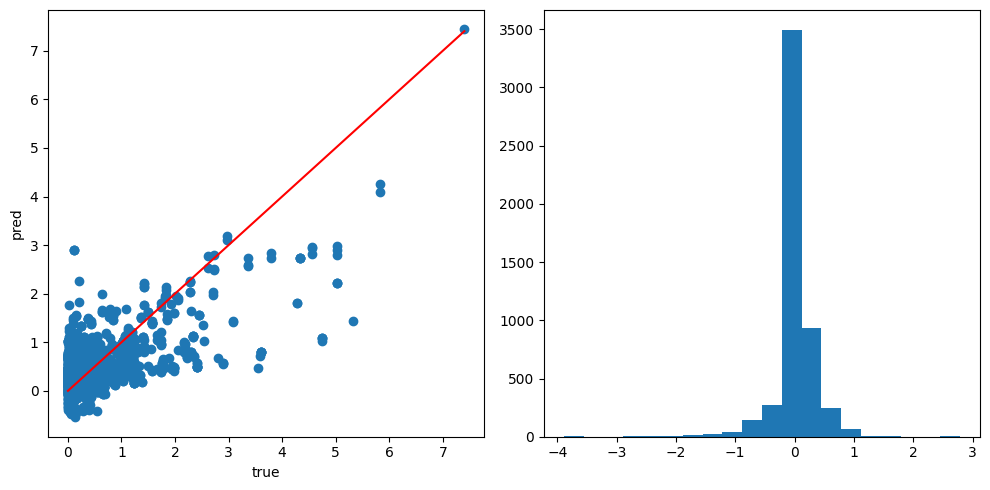

In [ ]:
y_pred = model(X_val).detach().numpy()
y_true = y_val.detach().numpy()
y_pred = y_pred[np.argwhere(y_pred<150)].reshape(-1,)
y_true = y_true[np.argwhere(y_true<150)].reshape(-1,)

for i in range(5):
    print(f"pred: {y_pred[i]}, true: {y_true[i]}")

fig, ax = plt.subplots(1,2, layout='tight', figsize=(10,5))
ax[0].scatter(y_true, y_pred)
ax[0].plot(np.linspace(np.min(y_true), np.max(y_true),100), np.linspace(np.min(y_true), np.max(y_true),100), color='red')
ax[1].hist(y_pred-y_true, bins=20);

ax[0].set_xlabel('true')
ax[0].set_ylabel('pred')

# Unsupervised

In [87]:
mldf.head(2)

,cluster_label,miles_walked_in_cluster,temperature_c,rel_humidity,cloud_cover,is_day,precipitation,supermarket,hair_care,grocery_or_supermarket,shopping_mall,bus_station,parking,bakery,liquor_store,storage,spa,park,museum,place_of_worship,subway_station,clothing_store,bar,tourist_attraction,cafe,health,airport,restaurant,lodging,transit_station,store,food
0,2,0.176681,17.927586,66.904978,96.155172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,0.369790,16.066854,64.661242,98.958333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
svd = TruncatedSVD(n_components=4)
tdf = svd.fit_transform(mldf.drop(columns=['cluster_label']))
tdf

array([[ 1.15845372e+02,  2.49560815e+01,  3.89503735e-01,
        -3.06002781e-01],
       [ 1.15775711e+02,  2.87525289e+01, -9.98976061e-01,
        -3.34123047e-01],
       [ 5.50592865e+01, -4.98731054e+01, -3.29026866e+00,
        -3.99925984e-02],
       ...,
       [ 1.37292954e+02,  1.06529711e+01,  9.94547458e-01,
        -2.24134899e-01],
       [ 1.37447653e+02,  7.16961000e+00,  3.95825005e-01,
        -2.93264158e-01],
       [ 1.37163015e+02,  1.07869439e+01,  1.49847291e+00,
        -2.65471102e-01]], shape=(560, 4))

In [108]:
svd.explained_variance_ratio_
mldf.columns[np.argmax(svd.components_[0])]

'temperature_c'

In [103]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='pca', perplexity=200, random_state=10).fit_transform(tdf)
X_embedded

array([[ 2.9665549 ,  1.968823  ],
       [ 3.0749373 ,  2.2276714 ],
       [-5.3611765 , -2.2738976 ],
       ...,
       [ 4.164581  , -0.43515706],
       [ 4.177153  , -0.8303313 ],
       [ 4.102038  , -0.4021292 ]], shape=(560, 2), dtype=float32)

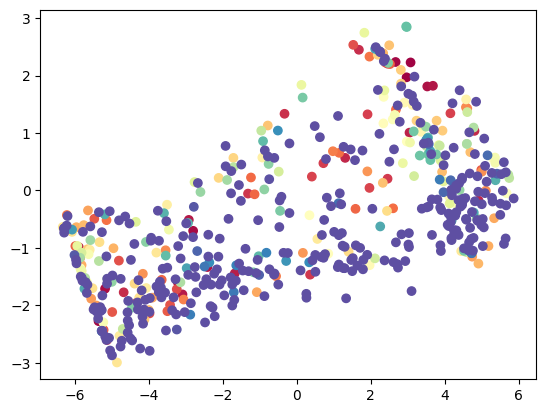

In [104]:
keys = mldf['cluster_label']
colors = plt.get_cmap(name='Spectral')
colors = [colors(i) for i in range(len(keys))]
plt.scatter(x = X_embedded[:,0], y = X_embedded[:,1], color=colors)

# Bottom